
# Here I'm process by chunks the entire region.

In [1]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
## Use the ggplot style
plt.style.use('ggplot')

In [2]:
from external_plugins.spystats import tools
%run ../testvariogram.py

/opt/conda/envs/biospytial/lib/python2.7/site-packages/IPython/core/pylabtools.py:168: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  safe_execfile(fname,*where,**kw)


In [3]:
section.shape

(1841, 46)

## Algorithm for processing Chunks
1. Make a partition given the extent
2. Produce a tuple (minx ,maxx,miny,maxy) for each element on the partition
3. Calculate the semivariogram for each chunk and save it in a dataframe
4. Plot Everything
5. Do the same with a mMatern Kernel

In [4]:
minx,maxx,miny,maxy = getExtent(new_data)

In [5]:
maxy

1556957.5046647713

In [6]:
## Let's build the partition
N = 30
xp,dx = np.linspace(minx,maxx,N,retstep=True)
yp,dy = np.linspace(miny,maxy,N,retstep=True)


In [7]:
xx,yy = np.meshgrid(xp,yp)

In [8]:
coordinates_list = [ (xx[i][j],yy[i][j]) for i in range(N) for j in range(N)]

In [9]:
from functools import partial
tuples = map(lambda (x,y) : partial(getExtentFromPoint,x,y,step_sizex=dx,step_sizey=dy)(),coordinates_list)

In [10]:
len(tuples)

900

In [11]:
chunks = map(lambda (mx,Mx,my,My) : subselectDataFrameByCoordinates(new_data,'newLon','newLat',mx,Mx,my,My),tuples)
chunks_sizes = map(lambda df : df.shape[0],chunks)

In [12]:
chunk_w_size = zip(chunks,chunks_sizes)

In [13]:
## Here we can filter based on a threshold
threshold = 10
nonempty_chunks_w_size = filter(lambda (df,n) : df.shape[0] > threshold ,chunk_w_size)
chunks_non_empty, chunks_sizes = zip(*nonempty_chunks_w_size)

In [14]:
lengths = pd.Series(map(lambda ch : ch.shape[0],chunks_non_empty))

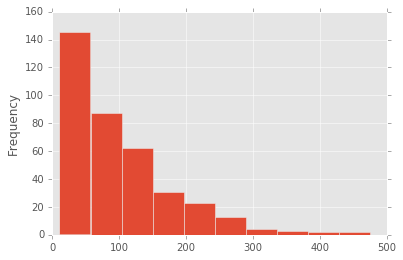

In [15]:
lengths.plot.hist()

In [20]:
cs = chunks_non_empty
variograms =map(lambda chunk : tools.Variogram(chunk,'residuals1',using_distance_threshold=200000),cs)

In [21]:
%time vars = map(lambda v : v.calculateEmpirical(),variograms)
%time vars = map(lambda v : v.calculateEnvelope(num_iterations=50),variograms)

CPU times: user 42.4 s, sys: 16 ms, total: 42.4 s
Wall time: 42.4 s
CPU times: user 33min 25s, sys: 236 ms, total: 33min 25s
Wall time: 33min 26s


## Take an average of the empirical variograms also with the envelope. 
### We will use the group by directive on the field lags


In [24]:
envslow = pd.concat(map(lambda df : df[['envlow']],vars),axis=1)
envhigh = pd.concat(map(lambda df : df[['envhigh']],vars),axis=1)
variogram = pd.concat(map(lambda df : df[['variogram']],vars),axis=1)
n_points = pd.concat(map(lambda df : df[['n_points']],vars),axis=1)

KeyError: "['n_points'] not in index"

In [23]:
lags = vars[0][['lags']]

In [ ]:
meanlow = list(envslow.apply(lambda row : np.mean(row),axis=1))
meanhigh = list(envhigh.apply(np.mean,axis=1))
meanvariogram = list(variogram.apply(np.mean,axis=1))
results = pd.DataFrame({'meanvariogram':meanvariogram,'meanlow':meanlow,'meanhigh':meanhigh})

In [ ]:
result_envelope = pd.concat([lags,results],axis=1)

In [ ]:
meanvg = tools.Variogram(section,'residuals1')

In [ ]:
meanvg.plot()

In [ ]:
meanvg.envelope.columns

In [ ]:
result_envelope.columns

In [ ]:
result_envelope.columns = ['lags','envhigh','envlow','variogram']

In [ ]:
meanvg.envelope = result_envelope

In [ ]:
meanvg.plot(refresh=False)